# Sentinel 5P Example

This examples computes daily minimum, maximum and/or smoothened mean NO2 values for a given year and spatial extent from Sentinel-5P data.

Upfront, you need to install the following libraries by executing `pip install openeo pandas plotly`:

- openeo
- pandas
- plotly

## Connect to openEO Platform

In [1]:
# Import required packages
import openeo
from openeo.processes import process

# Connect to the back-end and log in
connection = openeo.connect("openeo.cloud")
connection.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeocloud.vito.be/openeo/1.0.0/' with OidcBearerAuth>

## Details about the Sentinel-5P collection

In [65]:
connection.describe_collection("TERRASCOPE_S5P_L3_NO2_TD_V1")

{'assets': {'metadata_iso_19139': {'href': 'https://services.terrascope.be/collectioncatalogue/srv/api/records/urn:eop:VITO:TERRASCOPE_S5P_L3_NO2_TD_V1/formatters/xml?approved=true',
   'roles': ['metadata', 'iso-19139'],
   'title': 'ISO 19139 metadata',
   'type': 'application/vnd.iso.19139+xml'},
  'thumbnail': {'href': 'https://services.terrascope.be/collectioncatalogue/images/quicklooks/S5P_NO2_TD.png',
   'roles': ['thumbnail'],
   'title': 'Thumbnail',
   'type': 'image/png'}},
 'cube:dimensions': {'bands': {'type': 'bands', 'values': ['NO2']},
  't': {'extent': ['2019-01-01T00:00:00Z', None], 'type': 'temporal'},
  'x': {'axis': 'x', 'extent': [-180, 180], 'step': 0.05, 'type': 'spatial'},
  'y': {'axis': 'y', 'extent': [-89, 89], 'step': 0.05, 'type': 'spatial'}},
 'description': 'Daily NO2 composites, based on Sentinel-5p data.',
 'extent': {'spatial': {'bbox': [[-180, -89, 180, 89]]},
  'temporal': {'interval': [['2019-01-01T00:00:00Z', None]]}},
 'id': 'TERRASCOPE_S5P_L3_NO2_TD_V1',
 'keywords': ['VITO',
  'TERRASCOPE',
  'COPERNICUS',
  'ESA',
  'Orthoimagery',
  'SENTINEL-5P',
  'TROPOMI',
  'Level-3',
  'Atmospheric Components',
  'NO2',
  'Day'],
 'license': 'proprietary',
 'links': [{'href': 'https://sentinel.esa.int/documents/247904/690755/Sentinel_Data_Legal_Notice',
   'rel': 'license'},
  {'href': 'https://services.terrascope.be/wmts/v2',
   'rel': 'wmts',
   'wmts:layer': 'TERRASCOPE_S5P_L3_NO2_TD_V1'},
  {'href': 'https://openeocloud.vito.be/openeo/1.0.0/collections',
   'rel': 'root'},
  {'href': 'https://openeocloud.vito.be/openeo/1.0.0/collections',
   'rel': 'parent'},
  {'href': 'https://openeocloud.vito.be/openeo/1.0.0/collections/TERRASCOPE_S5P_L3_NO2_TD_V1',
   'rel': 'self'}],
 'providers': [{'name': 'VITO, on behalf of the Belgian Science Policy Office (BELSPO).',
   'roles': ['producer', 'licensor'],
   'url': 'https://terrascope.be'}],
 'stac_extensions': ['datacube',
  'https://stac-extensions.github.io/eo/v1.0.0/schema.json'],
 'stac_version': '0.9.0',
 'summaries': {'constellation': ['Sentinel-5'],
  'eo:bands': [{'gsd': 5600,
    'name': 'NO2',
    'offset': 0,
    'scale': 5,
    'type': 'int16',
    'unit': 'µmol/m²'}],
  'eo:gsd': [5600],
  'instruments': ['TROPOMI'],
  'platform': ['Sentinel-5P']},
 'title': 'Sentinel-5P Daily NO2, full archive, by Terrascope.'}

## Configure the script

- `year`: Set any year starting from 2019 for evaluation
- `extent`: Specify the spatial extent / geometry. Examples are given for NRW (state) or Münster (city)
- `moving_average_window`: The number of days for the moving average window (must be an odd number) - only applies if `method` is set to `mean`
- `method`: Which spatial aggregation method to use (one of: `min`, `max` or `mean`) - you can run the script multiple times with different methods to show them all in a single chart

In [55]:
results = {}
year = 2019

In [56]:
# NRW
extent = {
    "type": "Polygon",
    "coordinates": [[
        [9.02480809551023,50.520443333954574],
        [5.885010577442016,50.520443333954574],
        [5.885010577442016,52.14446135651707],
        [9.024808095510227,52.14446135651707],
        [9.02480809551023,50.520443333954574]
    ]]
}

In [66]:
# Münster
extent = {
    "type": "Polygon",
    "coordinates": [[
        [7.737228350528245,51.86687168604513],
        [7.507741544165615,51.86687168604513],
        [7.507741544165615,52.05013100121914],
        [7.737228350528245,52.05013100121914],
        [7.737228350528245,51.86687168604513]
    ]]
}

In [73]:
moving_average_window = 31
method = "max" # mean or max or min

## Run the process

In [74]:
udf = openeo.UDF("""
from pandas import Series
import numpy as np

def apply_timeseries(series: Series, context: dict) -> Series:
    return np.convolve(series, np.ones({n})/{n}, mode='same')
""".format(n = moving_average_window))

In [75]:
datacube = connection.load_collection("TERRASCOPE_S5P_L3_NO2_TD_V1", spatial_extent = extent, temporal_extent = [f"{year}-01-01", f"{year}-12-31"])
datacube = datacube.apply_dimension(dimension = "t", process = "array_interpolate_linear")
if method == "mean":
    datacube = datacube.apply_dimension(dimension = "t", process = udf)
datacube = datacube.aggregate_spatial(geometries = extent, reducer = method)
datacube = datacube.save_result(format = "JSON")
datacube

In [76]:
results[method] = connection.execute(datacube)

## Prepare the data for plotting

In [77]:
from pandas import DataFrame, Series
from datetime import datetime

values = {}
for m, result in results.items():
    dates = []
    for k, v in result.items():
        if m not in values:
            values[m] = []
        dates.append(datetime.strptime(k, "%Y-%m-%dT%H:%M:%SZ"))
        values[m].append(v[0][0])

df = DataFrame(values, dates, results.keys())
df

,mean,min,max
2019-01-01,NaN,NaN,NaN
2019-01-02,NaN,0.0,2.0
2019-01-03,NaN,0.0,2.0
2019-01-04,NaN,0.0,2.0
2019-01-05,NaN,-1.0,3.0
...,...,...,...
2019-12-27,9.486804,4.0,14.0
2019-12-28,8.917889,14.0,31.0
2019-12-29,8.545455,18.0,28.0
2019-12-30,8.348974,21.0,29.0


## Plot the data

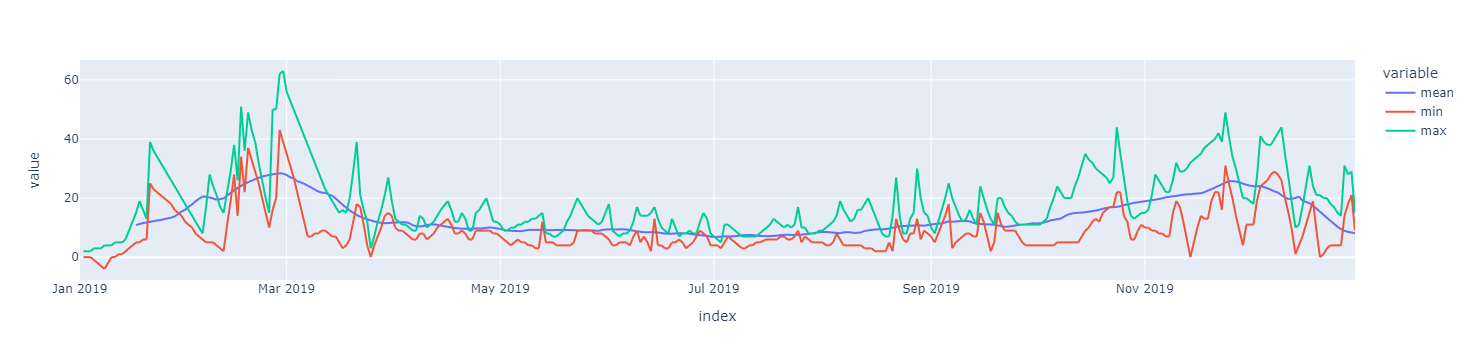

In [78]:
import plotly.express as px

fig = px.line(df)
fig.show()